### 指定參數

In [1]:
#輸出圖檔名、圖檔大小############
%load_ext autotime
dot_size = 3
length, width = 8, 12
n_neighbors = 10
min_dist = 0.99
metric = 'euclidean'
figure_name = "n_neighbors_"+str(n_neighbors)+"_min_dist_"+str(min_dist)+"_result"

time: 645 µs (started: 2021-06-09 21:56:20 +08:00)


### 導入套件

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

time: 14 s (started: 2021-06-09 21:56:20 +08:00)


### 資料前處理

In [3]:
data = pd.read_excel("./GTEx_NPC_data.xlsx", engine='openpyxl', header = None, index_col=0)
data = data.to_numpy()
label_data = pd.read_excel("./GTEx_NPC_data.xlsx", engine='openpyxl', header = None, index_col=None, usecols = "A")
label_data = label_data.to_numpy().flatten()
row_sums = data.sum(axis=1)
normalize_data = data / row_sums[:, np.newaxis]

time: 16.2 s (started: 2021-06-09 21:56:34 +08:00)


### UMAP參數修改

In [4]:
umap_x = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric=metric).fit_transform(normalize_data)

time: 20.3 s (started: 2021-06-09 21:56:50 +08:00)


### 畫圖前處理

In [5]:
matplotlib_axes_logger.setLevel('ERROR')
number = np.unique(label_data).shape[0]
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, number)]
color_dic = {}
cancers = np.unique(label_data).tolist()
for i in range(number):
    color_dic[cancers[i]] = colors[i]
x_dot = umap_x[:,0]
y_dot = umap_x[:,1]

dx = pd.DataFrame(x_dot, columns=['x'])
dy = pd.DataFrame(y_dot, columns=['y'])
df = pd.concat((dx, dy), axis=1)

time: 25.7 ms (started: 2021-06-09 21:57:10 +08:00)


### 輪廓係數法
- 用以找出最適合的K個clusters
- silhouette score = (b-a)/max(a,b)<br>
- silhoutte可找出同群資料點內最近/不同群越分散的值，b為不同群之間的點平均距離、a為同群之間的點距離

In [6]:
silhouette_avg = []
# 總共有30種tissues
for k in range(20,31):
    kmeans = KMeans(n_clusters=k).fit(df)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    silhouette_avg.append(silhouette_score(df, labels))
print(silhouette_avg)

[0.37420803, 0.38190365, 0.37856725, 0.38036144, 0.38182256, 0.37753785, 0.3807584, 0.38399923, 0.38099045, 0.37748918, 0.38216066]
time: 1min 3s (started: 2021-06-09 21:57:10 +08:00)


### K-means
- 將二維資料使用上格最適合的cluster number分群
- 分群結果存入kmeans變數

In [7]:
n_clusters = 20 + silhouette_avg.index(max(silhouette_avg))
kmeans = KMeans(n_clusters=n_clusters).fit(df)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

time: 1.59 s (started: 2021-06-09 21:58:14 +08:00)


### 畫圖
1.umap降為後結果圖<br>
2.輪廓係數法得到最適合的K<br>
3.Kmeans分群結果圖<br>

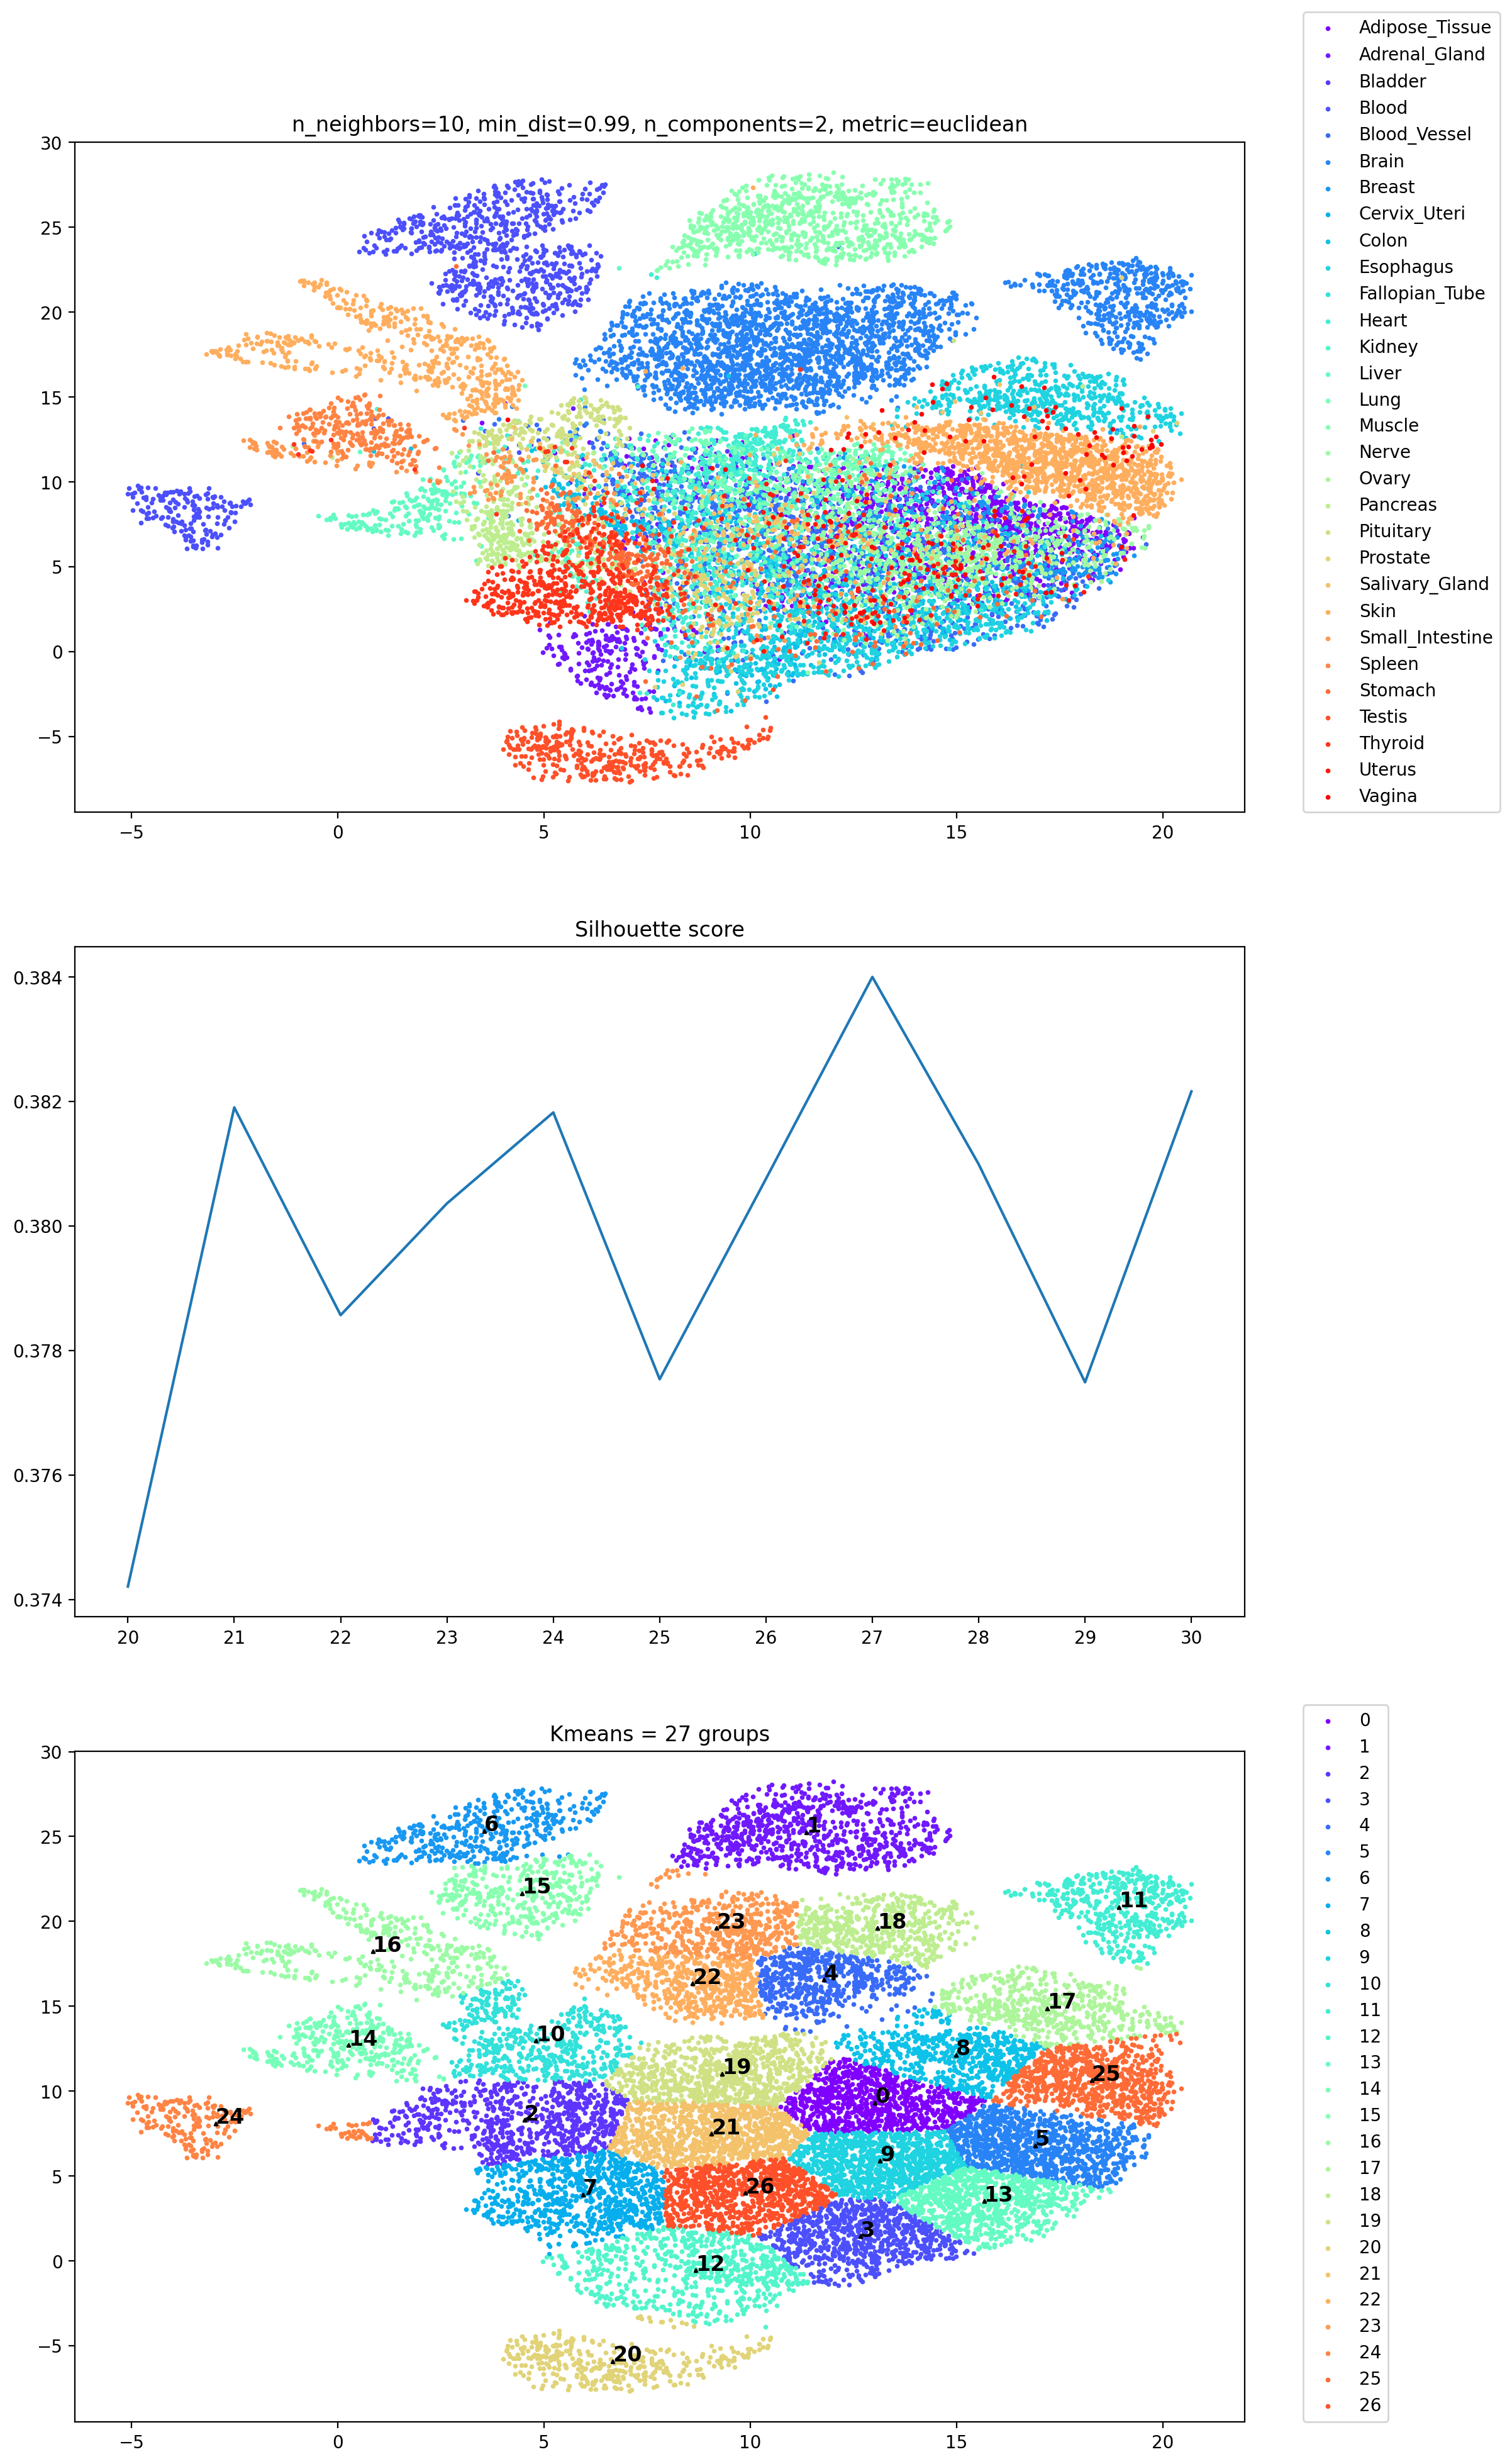

time: 6.88 s (started: 2021-06-09 21:58:16 +08:00)


In [8]:

fig = plt.figure(figsize=(width,3*length), dpi=200)
ax = plt.subplot(311)
plt.grid(False)
for g in np.unique(label_data):
	ix = np.where(label_data == g)
	ax.scatter(x_dot[ix], y_dot[ix], c = color_dic[g], label = g, s = dot_size)
ax.set_title('n_neighbors=' + str(n_neighbors) + ', min_dist=' + str(min_dist) + ', n_components=2' + ', metric=' + metric)
ax.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

plt.subplot(312)
plt.grid(False)
plt.title("Silhouette score")
plt.plot(range(20,31), silhouette_avg)
plt.xticks(range(20,31))

ax = plt.subplot(313)
plt.grid(False)
for i,g in zip(range(n_clusters),np.unique(label_data)):
	ax.scatter(df[labels==i].x, df[labels==i].y, c = color_dic[g], label = i, s = dot_size)
plt.scatter(centers.T[0], centers.T[1], c='black', marker='^', s=dot_size)
for j in range(centers.shape[0]):
    plt.text(centers.T[0][j], centers.T[1][j], str(j), fontdict={'color': 'black', 'weight': 'bold', 'size': 12})
ax.set_title("Kmeans = " + str(n_clusters) + " groups")
ax.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.savefig("./result/%s.jpg" % figure_name, dpi=300, bbox_inches = 'tight')

### Kmeans分群結果和組織分類是否高度重疊
使用tissue和cluster交集/tissue來看重疊性

In [9]:
result = np.zeros(120).reshape(30,4)
column_name = ['main_cluster','cluster_size','tissue_size','percentage']
type_list = []
tissue = pd.DataFrame(label_data, columns=['tissue'])
cluster = pd.DataFrame(labels, columns=['cluster'])
df_all = pd.concat((df,tissue,cluster), axis=1)
tissue_group = df_all.groupby('tissue')
tissue_types = tissue.drop_duplicates(ignore_index=True)
for i in range(tissue_types.size):
    type = tissue_types.tissue[i]
    type_list.append(type)
    tissue_size = tissue_group.get_group(type).groupby('cluster').size()
    arg_max = tissue_size.argmax()
    max_cluster_value = tissue_size.max()
    index_max = tissue_size.index[arg_max]
    tissue_sum = tissue_size.sum()
    percent = max_cluster_value/tissue_sum
    result[i] = [arg_max, max_cluster_value, tissue_sum, percent]
df_result = pd.DataFrame(result, columns=column_name)
for i in column_name:
    df_result[i] = pd.to_numeric(df_result[i], downcast='integer')
df_tissue = pd.DataFrame(type_list, columns=['tissue'])
df_result = pd.concat((df_tissue, df_result), axis=1)
df_result

,tissue,main_cluster,cluster_size,tissue_size,percentage
0,Muscle,0,784,803,0.976339
1,Blood_Vessel,13,256,1335,0.191760
2,Heart,11,356,861,0.413473
3,Uterus,1,34,142,0.239437
4,Vagina,11,28,156,0.179487
5,Breast,3,181,459,0.394336
6,Skin,13,760,1809,0.420122
7,Salivary_Gland,9,65,162,0.401235
8,Brain,1,580,2642,0.219531
9,Adrenal_Gland,5,177,258,0.686047


time: 74.5 ms (started: 2021-06-09 21:58:22 +08:00)


0.3732474902105545


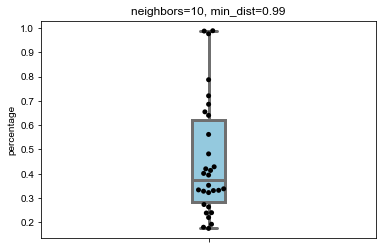

time: 506 ms (started: 2021-06-09 21:58:23 +08:00)


In [10]:
import seaborn as sns
medians = df_result.percentage.median()
print(medians)
plt.grid(False)
sns.set(style="whitegrid")
ax = sns.boxplot(y=df_result.percentage, orient="v", color="skyblue", width=0.1, linewidth=3) 
ax = sns.swarmplot(y = df_result.percentage, color = "black") 
ax.set_title("neighbors="+str(n_neighbors)+", min_dist="+str(min_dist))
plt.savefig("./result/%s_boxplot.jpg" % figure_name, dpi=300, bbox_inches = 'tight')